Sources Used:

To build implementation of RNN/GRU models: https://notebook.community/spro/practical-pytorch/char-rnn-generation/char-rnn-generation


Where I got textfile for Q4: https://nbcsportsgrouppressbox.com/2016/08/31/transcript-football-night-in-america-broadcast-team-previews-2016-nfl-season/

# Homework 6

In this homework you will be training and using a "char-RNN". This is the name given to a character-level recurrent neural network language model by [this famous blog post by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Before you start on the rest of the homework, please give the blog post a read, it's quite good!

I don't expect you to implement the char-RNN from scratch. Andrej's original char-rnn is in Torch (the predecessor to PyTorch that is not commonly used anymore). Fortunately, there are many other implementations of this model available; for example, there is one (in both mxnet and pytorch) in chapters 8 and 9 of [the textbook](http://d2l.ai), and another pytorch one [here](https://github.com/spro/char-rnn.pytorch). **Please use one of these example implementations (or another one that you find) when completing this homework**.

For this homework, please complete the following steps:

1. Download and tokenize the [Shakespeare dataset](http://www.gutenberg.org/files/100/100-0.txt) at a character level. I recommend basing your solution on the following code:
```Python
# Remove non-alphabetical characters, lowercase, and replace whitespace with ' '
raw_dataset = ' '.join(re.sub('[^A-Za-z ]+', '', text).lower().split())
# Maps token index to character
idx_to_char = list(set(raw_dataset))
# Maps character to token index
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
# Tokenize the dataset
corpus_indices = [char_to_idx[char] for char in raw_dataset]
```
1. Train a "vanilla" RNN (as described in chapter 9 of [the textbook](http://d2l.ai)) on the Shakespeare dataset. Report the training loss and generate some samples from the model at the end of training.
1. Train a GRU RNN (as described in chapter 10 of [the textbook](http://d2l.ai)) on the Shakespeare datatset. Is the final training loss higher or lower than the vanilla RNN? Are the samples from the model more or less realistic?
1. Find a smaller, simpler dataset than the Shakespeare data (you can find some ideas in Andrej's blog post, but feel free to get creative!) and train either the vanilla or GRU RNN on it instead. Is the final training loss higher or lower than it was for the Shakespeare data?m

Question 1:

In [1]:
import numpy as np
import re as re
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string


filename = 'shakespeare.txt'
with open(filename, encoding="utf8") as f:
    text = f.read()

raw_dataset = ' '.join(re.sub('[^A-Za-z ]+', '', text).lower().split())
idx_to_char = list(set(raw_dataset))
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
text_idx = [char_to_idx[char] for char in raw_dataset]
n_characters = len(idx_to_char)

text_len = len(text_idx)

Question 2:

In [2]:
chunk_len = 200

def random_chunk():
    start_index = np.random.randint(0, text_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return text_idx[start_index:end_index]


In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        ## Instead of using a one-hot encoding, use a nn.Embedding
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [4]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = string[c]
    return Variable(tensor)

In [5]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [6]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        
        # Add predicted character to string and use as next input
        predicted_char = top_i.item()
        predicted.append(predicted_char)
        inp = torch.tensor([predicted_char])

    return predicted

In [7]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        tar = torch.tensor([target[c].item()])
        loss += criterion(output, tar)

    loss.backward()
    decoder_optimizer.step()

    return loss / chunk_len

In [8]:
n_epochs = 5000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam (decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / n_epochs * 100, loss))
        starting_text = [int(char_to_idx[char]) for char in "wh"]
        encoded_text = evaluate(starting_text, 100)
        decoded_text = [idx_to_char[encoded_text[i]] for i in range(len(encoded_text))]
        print(''.join([str(element) for element in decoded_text]), "\n")

    if epoch % plot_every == 0:
        
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[(100 2%) 2.3322]
whestears chat door mysiass to the of no thercelestor shar ingecliemond the sousconsy pronce this shy  

[(200 4%) 2.1726]
whatlormance ale sumso the of bakt se and and thes forger primporshond you dowes and will an then dart 

[(300 6%) 2.3979]
whe lowhid thyt he partiongrhaven i wat handfour th bet hen ithtiit cong louth wat for thou coun aghan 

[(400 8%) 2.0424]
whel the drray bomy he muck like to gret forthrucold wond not my and sithin and moll ford grould to he 

[(500 10%) 2.0293]
wherisedite the morn not hy cantch my lord of herinewhod him doonderf not our you wheo housewor cold y 

[(600 12%) 1.8458]
what they be there in him the not at there in for soment and do and this and strence sumies and bearf  

[(700 14%) 1.9764]
why and me thy ligh a jessure seever of some aband doung him thou dose roms i whicks out have in mosel 

[(800 16%) 2.1962]
whald in but evandis not entletimitthere bromusend donget couss a gounglestean i this el theace i save 

[(900 18%) 2

In [9]:
def sample_text(starting_text, length, temp):
    test = evaluate([char_to_idx[starting_text[i]] for i in range(len(starting_text))], length, temp)
    test1 = [idx_to_char[test[i]] for i in range(len(test))]
    readableTest = ''.join([str(element) for element in test1 ])
    print(readableTest)
    return None

Here are some examples. While not every word is English and it doesn't make any sense (just like the original plays ;) ), the model seems to learn short English words, and many words present in Shakespeare plays seem to be here

In [10]:
sample_text("the king", 200, 0.5)

the king and the door and the gantter the boneside despool the favoppainions well the wome body his all and to not to lord a do sayed the sing to be to the to the the so with tent the in the but in some not s


In [11]:
sample_text("shall not", 200, 0.5)

shall not that the king and the so to emanneydo mastiees throughthe and the call the lich and and the man befor as the to but place had from to you gone in to do deat so a and to the and the mate to to you all


In [12]:
sample_text("thou", 200, 0.5)

thou and me the king and body the had praces in the be all the so the a come is the man in the earter the fall the good an in the blayorguingel surge the mast in the so in and a the mable my and in to to 


In [13]:
sample_text("hast", 200, 0.5)

hast is tent the the both refore the malce to you am to do so thou and hand the sir the do to my lord flood the and trange the lady with the do a king deservervout so the count the come to in and in be yo


In [14]:
sample_text("my lord", 200, 0.5)

my lord the land shall good stand to to bown he so i prong to confere to to to the do so good with to may made have in not done in in have there pargo the lord the but and the the so fall what thee the could


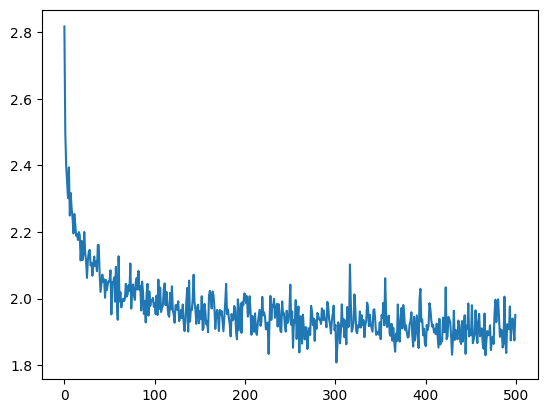

In [15]:
import matplotlib.pyplot as plt
for i in range(len(all_losses)):
    all_losses[i]=all_losses[i].detach().item()
plt.plot(all_losses)

In [16]:
all_losses[-1]

1.9509494304656982

The training loss is quite noisy here. It appears to plateau around 1.9 to 1.95. The average loss over the last 10 epochs is 1.95.

Question 3 - Replace the RNN with a GRU

In [17]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
       
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [18]:
def train_gru(inp, target):
    hidden = decoder_gru.init_hidden()
    decoder_gru.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder_gru(inp[c], hidden)
        tar = torch.tensor([target[c].item()])
        loss += criterion(output, tar)

    loss.backward()
    decoder_optimizer_gru.step()

    return loss / chunk_len

In [19]:
def evaluate_gru(prime_str='A', predict_len=100, temperature=0.9):
    hidden = decoder_gru.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder_gru(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder_gru(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        
        # Add predicted character to string and use as next input
        predicted_char = top_i.item()
        predicted.append(predicted_char)
        inp = torch.tensor([predicted_char])

    return predicted

In [20]:
decoder_gru = GRU(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer_gru = torch.optim.Adam (decoder_gru.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train_gru(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / n_epochs * 100, loss))
        starting_text = [int(char_to_idx[char]) for char in "wh"]
        encoded_text = evaluate_gru(starting_text, 100)
        decoded_text = [idx_to_char[encoded_text[i]] for i in range(len(encoded_text))]
        print(''.join([str(element) for element in decoded_text]), "\n")

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[(100 2%) 2.0844]
whir of ler sterah adpiess catweless well sherme bak blous wim in of mertith seraver bathe to you wles 

[(200 4%) 2.0611]
whwe some godling that o me have to hing allstionagos tod not urestich to the ulie grucure t eutheswha 

[(300 6%) 2.0215]
whtut miyenger tunge may by fey thet you a my sto the i anouss i me see ever dere and that noventerfri 

[(400 8%) 2.0774]
who dighe be there onspervevien agandnophall dood gerif in acd my me tere sloth shour the but sance se 

[(500 10%) 1.7604]
why my lame correat queol do my what a mistne a mince mourt swonterat airs ay ham as athid i fidseonce 

[(600 12%) 1.9681]
whort is wouls prelhatbod loke heed will geer what bindeld thou thou falland his is drengehif ance sin 

[(700 14%) 2.0262]
whers mand oftill my caplan in deitior piver of to criver his could be it belive as swam to not with t 

[(800 16%) 2.1504]
whow very and him will tall are as lovefore and ble gare whear why and bests do that ams him humpardsi 

[(900 18%) 2

Here are some examples after training the GRU. It looks to me as if there are more proper English words here, and some natable longer words. Also, I noticed there are some character names from the play "Coriolanus" here which is interesting. 

In [21]:
def sample_text_gru(starting_text, length, temp):
    test = evaluate_gru([char_to_idx[starting_text[i]] for i in range(len(starting_text))], length, temp)
    test1 = [idx_to_char[test[i]] for i in range(len(test))]
    readableTest = ''.join([str(element) for element in test1 ])
    print(readableTest)
    return None

In [22]:
sample_text_gru("the lord", 200, 0.5)

the lord that the know had the poor that but be could this pleasing are that be me thank thee entrient the renences the pater be he comes comperin coridisthe do has and the will pity and he will that with the


In [23]:
sample_text_gru("hath", 200, 0.5)

hath i have he will the care that chardy when the word how the will they parin the can the will hath that i princenter wideshe prepenter i call the will this the will that thou be and the will them so the


In [24]:
sample_text_gru("thou", 200, 0.5)

thou know what with the king of had brothand the king that and i comes do is the will the prince power the contle the king which that the promand he woman made this made the compell the pring strease he c


In [25]:
sample_text_gru("shall not", 200, 0.5)

shall not that made be gentle me the poor the paisand be graces the prother that the pray that his repheal the storts then ill been we was by his people that that the brotherwhich the is and the that be gentle


In [26]:
sample_text_gru("pray", 200, 0.5)

pray brawhere poor gentleman the fine the prate enter not he traints and than the prince i had the she partsand the words the will be do with have what the be dissand be brooth be despect that be peens th


In [27]:
sample_text_gru("straight", 200, 0.5)

straight the play the will master kinghis bless i be marghthat the worsif henfeath the paros that make the poor and did that the presents ward poor the contrain have what thou so whose the call in thee peatss


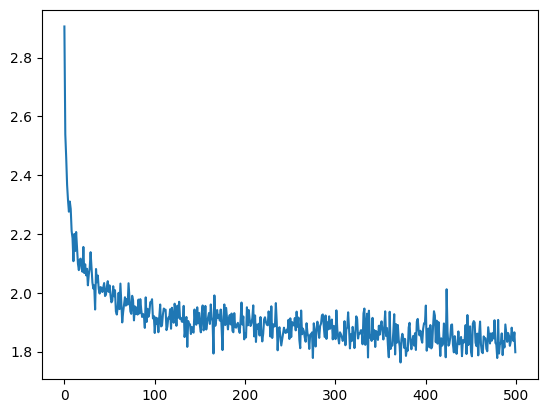

In [28]:
for i in range(len(all_losses)):
    all_losses[i]=all_losses[i].detach().item()
plt.plot(all_losses)

Using the GRU model, the training loss remains quite noisy, but appears to be lower than when the vanilla RNN was trained (it appears to plateau around 1.85 instead of 1.95). The average loss over the last 10 epochs was 1.798.

In [29]:
all_losses[-1]

1.797696828842163

Question 4 - Done on a transcript of football night in America

In [32]:
# Prepare the data

filename = 'footballtranscript.txt'
with open(filename, encoding="utf8") as f:
    text = f.read()

raw_dataset = ' '.join(re.sub('[^A-Za-z ]+', '', text).lower().split())
idx_to_char = list(set(raw_dataset))
char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
text_idx = [char_to_idx[char] for char in raw_dataset]
n_characters = len(idx_to_char)

text_len = len(text_idx)

In [35]:
decoder_gru = GRU(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer_gru = torch.optim.Adam (decoder_gru.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0
n_epochs = 1000

for epoch in range(1, n_epochs + 1):
    loss = train_gru(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / n_epochs * 100, loss))
        starting_text = [int(char_to_idx[char]) for char in "wh"]
        encoded_text = evaluate_gru(starting_text, 100)
        decoded_text = [idx_to_char[encoded_text[i]] for i in range(len(encoded_text))]
        print(''.join([str(element) for element in decoded_text]), "\n")

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[(100 10%) 1.7917]
whren the that what id thine ke ait mee the fot to the fill lody sully bow wurppreach the homill and t 

[(200 20%) 1.6932]
wht think to in foother going and tasube onted thingo the guess ntill reall a rome the a plemarter i d 

[(300 30%) 1.3682]
what or on the comering foing the upsolut thirstich conirk in every elly to sieding to yuns and night  

[(400 40%) 1.3951]
whes away for the showst and caronvolve shought the shing groding to nighation in and when youc did on 

[(500 50%) 1.3176]
whonn pust a lot int of to becaue part told out a but me our durgy i dids and in but the beintirico it 

[(600 60%) 1.4327]
whry what ever it there and better them if you i wags you gamerodney miking young in the other but for 

[(700 70%) 1.4844]
who it imboring tirco and they all olive to everybody neso side with uper bot in a ppersigige they he  

[(800 80%) 1.2501]
whed running the second pall rove secod hom and they at the seecly sayer had as prosuple treasit surpr 

[(900 90

When using this smaller dataset (about 30kB instead of 5.5MB), we produce more coherent text and have a much lower training loss. The sentences do not make sense, but nmost words are real words, and there are some long words, like "opportunity".  In the samples below, there are many football terms present including "NFL", "super bowl", "start", "quarterback" "sunday", some player or analyst names (like tony dungy, tirico, belichich, rodney). Also some broadcast terms like "studio" and "station" are present.

In [36]:
sample_text_gru("quarter", 200, 0.5)

quarterback and the studio i look for me are was and that tell be and the part of the preseason and the probably so and masts show were jone you have to defenses and a couple with and the first of the guy wi


In [38]:
sample_text_gru("sunday", 200, 0.5)

sunday night and the lot a was and there and to for me just and there and the formaris and to be at they are super been week and that we arenth not of them the arento be and to be a clead the seen there goi


In [47]:
sample_text_gru("foot", 200, 0.5)

football be and a be in the number of the nfl and think it work in a going to sto the great defenves to be a lot of for me with the not on the fort and and lats on the show to be a couple great and hes go


In [48]:
sample_text_gru("tony", 200, 0.5)

tony dungy hes defensese were great for the back to be a chance to be a the probably the for mike the forment of they have the fact and then in the the preseason at one what were great steal had not of th


In [41]:
sample_text_gru("football", 200, 0.5)

football and a super bob a great show in and the seen week and mike in a great a supt one a super bowl had the they are the time to the preciatent and the need to be a great football and a sunday night and th


In [60]:
sample_text_gru("belic", 200, 0.5)

belichick in the fired about the nfl the nfl the new the prectain a great show in the are the fund the arolon and i worked to for me and the in the seen the the not chris for me how us going to be a great 


In [61]:
sample_text_gru("a", 200, 0.5)

act the say the studio and the the studio be about the first for mike in a really as how a football and really group it sunday and there going to for me we think its the studio realy and that has the b


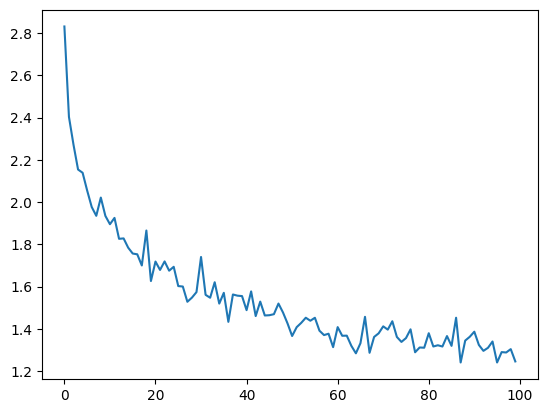

In [64]:
#for i in range(len(all_losses)):
    #all_losses[i]=all_losses[i].detach().item()
plt.plot(all_losses)

In [46]:
all_losses[-1]

1.2461650371551514

The training loss is still noisy, but is clearly much lower, plateauing around 1.25 (instead of 1.8 in the Shakespeare case). The average training loss is much lower over the last 10 epochs than with the Shakespeare dataset, at 1.25